In [1]:
import torch

In [2]:
if torch.backends.mps.is_available():
    print("✅ MPS (Metal) backend is available and enabled.")
else:
    print("❌ MPS not available.")

✅ MPS (Metal) backend is available and enabled.


### ** Outline: Frontiers in Recommendation Systems**

**Part I: From Static Predictions to Adaptive Learning**

*   **Chapter 1: Personalization in Practice: A Batched Learning Baseline**
    *   1.1 Introduction: The Personalization Challenge at Zooplus
    *   1.2 The Proving Ground: Simulating a Realistic User Environment
    *   1.3 The Baseline: An "Embedding+MLP" Deep Learning Recommender
    *   1.4 Critical Analysis: The Inherent Flaws of the Batched Approach
    *   1.5 Chapter Summary and Transition to Online Learning

*   **Chapter 2: The Adaptive Recommender: Contextual Bandits in Action**
    *   2.1 Introduction: Escaping the Static World with the Explore-Exploit Dilemma
    *   2.2 The Frontier Technique: The Linear Upper Confidence Bound (LinUCB) Algorithm
    *   2.3 Implementing the LinUCB Agent for Zooplus
    *   2.4 The Online Arena: A Head-to-Head Simulation vs. the Batched Model
    *   2.5 Analysis of Results: Visualizing the Power of Continuous Learning
    *   2.6 Conclusion: The Benefits and Limitations of the Bandit Approach

**Part II: Understanding the User's Journey and Network**

*   **Chapter 3: The Session-Aware Recommender: Sequential Models for In-the-Moment Personalization**
    *   3.1 Introduction: Beyond a Single Click - Modeling User Intent
    *   3.2 The Transformer Architecture for Recommendations
    *   3.3 Building a Behavioral Sequence Transformer (BST) for Zooplus
    *   3.4 Training and Evaluating the Sequential Model
    *   3.5 Discussion: When Sequence Matters Most

*   **Chapter 4: Learning from the Crowd: Graph-Based Personalization**
    *   4.1 Introduction: The "Users Who Bought This Also Bought..." Superpower
    *   4.2 Representing Zooplus as a Graph
    *   4.3 The Frontier Technique: Graph Convolutional Networks (GCNs)
    *   4.4 Implementing a Simplified GCN for Collaborative Filtering
    *   4.5 Generating Recommendations from Graph Embeddings
    *   4.6 Conclusion: Blending Content, Collaborative, and Contextual Signals

***



## **Part I: From Static Predictions to Adaptive Learning**

### **Chapter 1: Personalization in Practice: A Batched Learning Baseline**

#### **1.1 Introduction: The Personalization Challenge at Zooplus**

Welcome. In this book, we will embark on a journey to the frontiers of modern recommendation systems. Our goal is not simply to understand these systems in the abstract, but to build them, piece by piece, developing the intuition and practical skills required to deploy them in the real world. Our laboratory for this journey will be a simulated version of a large-scale e-commerce platform: **Zooplus**, Europe's leading online retailer for pet supplies.

Imagine a user, let's call her Anna, who has just adopted a German Shepherd puppy. She visits Zooplus for the first time. What should the website show her on its homepage? A generic list of "bestselling products"? This might include premium cat food and bird cages—items that are popular overall but completely irrelevant to Anna. This is a missed opportunity. A truly intelligent system would infer, perhaps from her first few clicks, that she is a new puppy owner and immediately start personalizing her experience, surfacing puppy-specific food, durable chew toys, and training pads.

This is the essence of personalization: **the process of tailoring an experience to the specific needs, preferences, and context of an individual user.** For an e-commerce site like Zooplus, effective personalization is not a luxury; it is the engine of user engagement, customer loyalty, and ultimately, commercial success. Our core objective will be to build systems that maximize a key proxy for engagement: the **click-through rate (CTR)**, or the probability that a user will click on a recommended item.

Over the next two chapters, we will construct and contrast two fundamentally different approaches to this problem. In this chapter, we will begin by building a strong, industry-standard baseline: a deep learning model trained on a static, historical log of user interactions. This "batched" approach is a powerful workhorse, but as we will see, it suffers from critical flaws. It is slow to adapt, blind to new products, and incapable of intelligent exploration.

Understanding these limitations will motivate our leap, in Chapter 2, to a more dynamic and intelligent paradigm: the **contextual bandit**. This will be our first foray into reinforcement learning, where our system learns continuously from every single user interaction, intelligently balancing the need to exploit known preferences with the drive to explore new possibilities. Let us begin by creating the world in which our algorithms will live.

#### **1.2 The Proving Ground: Simulating a Realistic User Environment**

Before we can write a single line of a recommendation algorithm, we face a fundamental problem. The most advanced personalization techniques, such as the bandits we will soon study, are *online* algorithms. They are designed to learn interactively, in real-time, with live users. We cannot, of course, experiment directly on Zooplus's production systems. Doing so would be costly, risky, and slow.

The solution is to build a **simulation**: a digital replica of the user-item interaction environment. A well-designed simulation provides a safe, fast, and repeatable "proving ground" where we can deploy, test, and compare our algorithms. It allows us to run thousands of interactions in seconds and to rigorously evaluate how well an algorithm learns over time.

Our simulation must be simple enough to be tractable, yet realistic enough to be meaningful. It will consist of three core components:

1.  **A Product Catalog:** A collection of items that can be recommended. Each item will have attributes, such as its category and a base popularity score.
2.  **User Personas:** We will not model a single, generic "average user." Real-world user populations are heterogeneous. We will define distinct personas (e.g., "The Cat Connoisseur," "The New Puppy Parent") with different underlying preferences.
3.  **An Interaction Model (The Reward Function):** The logic that determines the outcome (a click or no-click) when a specific user is shown a specific product. Crucially, this model must be **stochastic** (i.e., contain randomness) to reflect the inherent noise and unpredictability of human behavior.

Let's build this simulation in Python.

**Code Block 1.1: The Zooplus Simulation Environment**

```python
# main_dependencies.py
# Run this cell once to install all necessary libraries for the upcoming chapters.
# !pip install numpy pandas scikit-learn tensorflow

import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category, base popularity).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        self.product_features = self._get_product_features()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        categories = ['Dog Food', 'Cat Food', 'Dog Toy', 'Cat Toy', 'Fish Supplies']
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.choice(categories, self.n_products),
            # Base popularity score for each product (e.g., from global sales)
            'base_popularity': self.rng.uniform(0.1, 0.5, self.n_products)
        }
        return pd.DataFrame(product_data)

    def _get_product_features(self):
        """One-hot encodes product categories to create a feature matrix."""
        return pd.get_dummies(self.products['category'], prefix='cat').astype(float).values

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences."""
        return {
            'new_puppy_parent': {'Dog Food': 0.9, 'Dog Toy': 0.8, 'Cat Food': 0.1, 'Cat Toy': 0.1, 'Fish Supplies': 0.05},
            'cat_connoisseur':  {'Dog Food': 0.1, 'Dog Toy': 0.05, 'Cat Food': 0.9, 'Cat Toy': 0.85, 'Fish Supplies': 0.1},
            'budget_shopper':   {'Dog Food': 0.5, 'Dog Toy': 0.4, 'Cat Food': 0.5, 'Cat Toy': 0.4, 'Fish Supplies': 0.3},
            'fish_hobbyist':    {'Dog Food': 0.05, 'Dog Toy': 0.05, 'Cat Food': 0.1, 'Cat Toy': 0.1, 'Fish Supplies': 0.95}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def _sigmoid(self, x):
        """Sigmoid function to map a score to a probability."""
        return 1 / (1 + np.exp(-x))

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a reward (1 for click, 0 for no-click).
        
        The click probability is a function of:
        - The user's affinity for the product's category.
        - The product's base popularity.
        - Random noise.
        """
        if user_id not in self.user_to_persona_map or product_id >= self.n_products:
            return 0 # Invalid user or product
            
        # Get user and product info
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_info = self.products.loc[product_id]
        product_category = product_info['category']
        product_popularity = product_info['base_popularity']
        
        # Calculate affinity score
        affinity = persona_prefs.get(product_category, 0.1) # Default affinity for unknown categories
        
        # Combine scores and add noise. We scale the scores to create a reasonable logit.
        logit = 3 * affinity + 1 * product_popularity - 2.5 # The constants are chosen to center the CTR
        
        # Introduce noise: some users might click on things they don't "like"
        logit += self.rng.normal(0, 0.5)
        
        # Convert logit to a probability
        click_prob = self._sigmoid(logit)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        reward = self.rng.binomial(1, click_prob)
        
        return reward

    def get_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

# --- Example Usage ---
# Let's instantiate the simulator and see it in action
sim = ZooplusSimulator(seed=42)

# Get a random user
user_id = sim.get_user()
persona = sim.user_to_persona_map[user_id]
print(f"Simulating for User ID: {user_id}, who is a '{persona}'")

# Let's test this user's reaction to a few products
for product_id in [1, 2, 10, 11]:
    product_cat = sim.products.loc[product_id, 'category']
    reward = sim.get_reward(user_id, product_id)
    print(f"  - Recommended Product {product_id} (Category: {product_cat})... Clicked: {'Yes' if reward == 1 else 'No'}")

```

**Dissecting the Simulation:**

*   **`_create_product_catalog`**: This method generates our inventory. Each of the 50 products is assigned a category and a `base_popularity` score, which represents its general appeal independent of any specific user.
*   **`_create_user_personas`**: Here we define the "ground truth" of our users' tastes. The `'new_puppy_parent'` has a high affinity (0.9) for `'Dog Food'`, while the `'cat_connoisseur'` has a low affinity (0.1) for it. This dictionary is the core of our personalization problem.
*   **`get_reward`**: This is the heart of the simulation. It doesn't just check if a user likes a category. It combines the user's `affinity` with the item's `product_popularity`, adds random noise (`rng.normal`), and then uses a sigmoid function to produce a final click probability. This ensures that even a `cat_connoisseur` might *occasionally* click a dog toy (perhaps as a gift), and a `new_puppy_parent` won't *always* click on puppy food. This noise is what makes the problem challenging and realistic.

With this simulation in hand, we can now generate the historical data needed to train our first model.



In [3]:
# !pip install numpy pandas scikit-learn tensorflow

import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category, base popularity).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        self.product_features = self._get_product_features()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        categories = ['Dog Food', 'Cat Food', 'Dog Toy', 'Cat Toy', 'Fish Supplies']
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.choice(categories, self.n_products),
            # Base popularity score for each product (e.g., from global sales)
            'base_popularity': self.rng.uniform(0.1, 0.5, self.n_products)
        }
        return pd.DataFrame(product_data)

    def _get_product_features(self):
        """One-hot encodes product categories to create a feature matrix."""
        return pd.get_dummies(self.products['category'], prefix='cat').astype(float).values

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences."""
        return {
            'new_puppy_parent': {'Dog Food': 0.9, 'Dog Toy': 0.8, 'Cat Food': 0.1, 'Cat Toy': 0.1, 'Fish Supplies': 0.05},
            'cat_connoisseur':  {'Dog Food': 0.1, 'Dog Toy': 0.05, 'Cat Food': 0.9, 'Cat Toy': 0.85, 'Fish Supplies': 0.1},
            'budget_shopper':   {'Dog Food': 0.5, 'Dog Toy': 0.4, 'Cat Food': 0.5, 'Cat Toy': 0.4, 'Fish Supplies': 0.3},
            'fish_hobbyist':    {'Dog Food': 0.05, 'Dog Toy': 0.05, 'Cat Food': 0.1, 'Cat Toy': 0.1, 'Fish Supplies': 0.95}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def _sigmoid(self, x):
        """Sigmoid function to map a score to a probability."""
        return 1 / (1 + np.exp(-x))

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a reward (1 for click, 0 for no-click).
        
        The click probability is a function of:
        - The user's affinity for the product's category.
        - The product's base popularity.
        - Random noise.
        """
        if user_id not in self.user_to_persona_map or product_id >= self.n_products:
            return 0 # Invalid user or product
            
        # Get user and product info
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_info = self.products.loc[product_id]
        product_category = product_info['category']
        product_popularity = product_info['base_popularity']
        
        # Calculate affinity score
        affinity = persona_prefs.get(product_category, 0.1) # Default affinity for unknown categories
        
        # Combine scores and add noise. We scale the scores to create a reasonable logit.
        logit = 3 * affinity + 1 * product_popularity - 2.5 # The constants are chosen to center the CTR
        
        # Introduce noise: some users might click on things they don't "like"
        logit += self.rng.normal(0, 0.5)
        
        # Convert logit to a probability
        click_prob = self._sigmoid(logit)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        reward = self.rng.binomial(1, click_prob)
        
        return reward

    def get_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

# --- Example Usage ---
# Let's instantiate the simulator and see it in action
# sim = ZooplusSimulator(seed=42)
sim = ZooplusSimulator(seed=2)

# Get a random user
user_id = sim.get_user()
persona = sim.user_to_persona_map[user_id]
print(f"Simulating for User ID: {user_id}, who is a '{persona}'")

# Let's test this user's reaction to a few products
for product_id in [1, 2, 10, 11]:
    product_cat = sim.products.loc[product_id, 'category']
    reward = sim.get_reward(user_id, product_id)
    print(f"  - Recommended Product {product_id} (Category: {product_cat})... Clicked: {'Yes' if reward == 1 else 'No'}")

Simulating for User ID: 125, who is a 'new_puppy_parent'
  - Recommended Product 1 (Category: Cat Food)... Clicked: No
  - Recommended Product 2 (Category: Dog Food)... Clicked: Yes
  - Recommended Product 10 (Category: Fish Supplies)... Clicked: No
  - Recommended Product 11 (Category: Cat Toy)... Clicked: No


#### **1.3 The Baseline: A Batched Deep Learning Recommender**

Our first approach will be to build a model based on the widely successful **"Embedding + MLP"** pattern. This is a cornerstone of modern deep learning-based recommenders, used in various forms by companies like YouTube and TripAdvisor.

The philosophy is straightforward: we will first use our simulator to generate a large, static log of historical interactions—imagine this as the server logs from the past month. Then, we will train a neural network on this "batch" of data to learn to predict the probability of a click for any given `(user, item)` pair.

**Step 1: Generate the Historical Data**

We will run our simulation for a large number of steps to create a dataset. Each row will represent one recommendation event.

**Code Block 1.2: Generating a Batched Dataset**
```python
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids = []
    product_ids = []
    clicks = []
    
    print(f"Generating {num_interactions} interaction records...")
    for _ in range(num_interactions):
        # In a real system, the product shown would be from a previous recommender.
        # Here, we simplify by showing a random product to a random user.
        user_id = simulator.get_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    return pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })

# Generate a dataset of 100,000 interactions
training_data = generate_training_data(sim, 100_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")
```

This `training_data` DataFrame is now our ground truth. It's a static snapshot of the past. Our task is to build a model that can learn the underlying preference patterns hidden within this data.



In [4]:
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids = []
    product_ids = []
    clicks = []
    
    print(f"Generating {num_interactions} interaction records...")
    for _ in range(num_interactions):
        # In a real system, the product shown would be from a previous recommender.
        # Here, we simplify by showing a random product to a random user.
        user_id = simulator.get_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    return pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })

# Generate a dataset of 100,000 interactions
training_data = generate_training_data(sim, 100_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")

Generating 100000 interaction records...

Generated Training Data:
   user_id  product_id  clicked
0      770           6        0
1      916           2        0
2      589          48        0
3      929          10        0
4      282           0        0

Overall Click-Through Rate (CTR) in dataset: 29.16%


*Comment*: maybe we should realistically lower the CTR here, but this is a toy example :)

**Step 2: Designing the "Embedding + MLP" Model in PyTorch**

Our model needs to take a `user_id` and a `product_id` as input and output a single number: the predicted CTR. How can a neural network handle raw IDs? The answer, as before, lies in **embedding layers**.

In PyTorch, an embedding layer (`torch.nn.Embedding`) is a lookup table that maps a high-dimensional, sparse identifier (like a `user_id` from 1 to 1000) to a low-dimensional, dense vector of floating-point numbers. This vector, the "embedding," is not predefined; its values are learned during training.

Our model architecture will be:
1.  **Embedding Layers:** We will have two `nn.Embedding` layers, one for users and one for products.
2.  **Concatenation:** The resulting user and product vectors are concatenated (`torch.cat`) into a single, larger vector.
3.  **MLP Tower:** This combined vector is passed through one or more `nn.Linear` layers with ReLU activation. This Multi-Layer Perceptron (MLP) is where the model learns complex, non-linear interactions.
4.  **Output Layer:** A final `nn.Linear` layer with a single output neuron, followed by a `torch.sigmoid` activation function to produce our predicted CTR.

Unlike Keras, which abstracts away much of the data handling and training process, PyTorch requires a more explicit approach. We will need to:
*   Define our model as a class that inherits from `torch.nn.Module`.
*   Wrap our pandas DataFrame in a `torch.utils.data.Dataset` to prepare it for the model.
*   Use a `DataLoader` to efficiently create batches of data.
*   Write an explicit training loop to iterate over the data, compute loss, and update the model's weights.

This explicit process gives the developer immense control and is a hallmark of the PyTorch framework.

**Code Block 1.3: Building and Training the Batched PyTorch Model**

```python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# First, ensure the main dependencies are installed for PyTorch
# !pip install numpy pandas scikit-learn torch

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    """Custom PyTorch Dataset for our recommender data."""
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    """Embedding + MLP model in PyTorch."""
    def __init__(self, n_users, n_products, embedding_dim=16):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        
        # Concatenate the embeddings
        x = torch.cat([user_embeds, product_embeds], dim=1)
        
        # Pass through the MLP tower
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output layer
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
# Split data into training and validation sets
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)

train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for CTR prediction
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)

print("PyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
n_epochs = 5
for epoch in range(n_epochs):
    batch_model.train() # Set model to training mode
    total_loss = 0
    for users, products, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = batch_model(users, products).squeeze()
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # --- Validation Phase ---
    batch_model.eval() # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad(): # No need to calculate gradients for validation
        for users, products, labels in val_loader:
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {total_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")

# Let's save the model's learned parameters for later use in Chapter 2
torch.save(batch_model.state_dict(), "batch_recommender_model.pth")
```

**Dissecting the PyTorch Implementation:**

*   **`RecommenderDataset`**: This class is our bridge between the pandas DataFrame and PyTorch. It implements `__len__` and `__getitem__`, which are required by PyTorch's `DataLoader` to know the total size of the dataset and how to retrieve a single data point.
*   **`MLPRecommender`**: This class defines our network's layers in `__init__` and the flow of data through those layers in the `forward` method. This separation of structure and execution is a core design principle of `nn.Module`.
*   **`DataLoader`**: This is a powerful PyTorch utility that takes our `Dataset` and automatically handles batching, shuffling, and even parallel data loading.
*   **The Training Loop**: This is the most significant departure from Keras. We explicitly loop through our `train_loader`. In each iteration, we perform the five sacred steps of training: zero gradients, forward pass, compute loss, backward pass, and update weights. This hands-on approach provides complete transparency and control over the training process.
*   **`model.train()` and `model.eval()`**: These are important calls. They tell layers like Dropout or BatchNorm (which we haven't used here, but are common) whether to behave in training mode or inference mode. It's a best practice to always include them.
*   **Saving the Model**: We save the `state_dict()` (state dictionary), which contains all the learned weights and biases of the model. This is the recommended way to save a PyTorch model, as it is more portable than saving the entire model object.

We now have a strong baseline model, trained on our static historical data. On the surface, it is a powerful, modern recommender. However, its static nature hides deep-seated problems that will become apparent as soon as the world changes. We will dissect these flaws in the next section, setting the stage for a much more dynamic solution.

In [5]:
# # --- Now we will build a baseline deep learning model using PyTorch ---
# This model will be a simple MLP that takes user and product IDs as inputs and predicts the click probability (CTR).
# We will use PyTorch to implement this model, leveraging its powerful capabilities for deep learning and GPU acceleration.
# We will be moving tensors to the MPS (Metal Performance Shaders) backend for efficient computation on Apple Silicon devices.
# Ensure you have the latest version of PyTorch installed with MPS support.
# If you are using a different backend (like CUDA for NVIDIA GPUs), adjust the code accordingly
# to use `torch.device('cuda')` instead of `torch.device('mps')
# and ensure you have the appropriate PyTorch version installed.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# First, ensure the main dependencies are installed for PyTorch
# !pip install numpy pandas scikit-learn torch


# --- Device Configuration ---
# Check if MPS is available (for Apple Silicon Macs)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device.")
# Check if CUDA is available (for NVIDIA GPUs)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    """Custom PyTorch Dataset for our recommender data."""
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    """Embedding + MLP model in PyTorch."""
    # REVISION: Increased embedding_dim from 16 to 32
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        # REVISION: Increased MLP layer sizes
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        
        # Concatenate the embeddings
        x = torch.cat([user_embeds, product_embeds], dim=1)
        
        # Pass through the MLP tower
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Output layer
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
# Split data into training and validation sets
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)

train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
# !!! IMPORTANT: Move the model to the selected device !!!
batch_model.to(device)

criterion = nn.BCELoss() # Binary Cross-Entropy Loss for CTR prediction
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)

print("PyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
# n_epochs = 5
# REVISION: Increased epochs from 5 to 10
n_epochs = 10
for epoch in range(n_epochs):
    batch_model.train() # Set model to training mode
    total_loss = 0
    for users, products, labels in train_loader:
        # !!! IMPORTANT: Move data tensors to the selected device !!!
        users, products, labels = users.to(device), products.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = batch_model(users, products).squeeze()
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # --- Validation Phase ---
    batch_model.eval() # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad(): # No need to calculate gradients for validation
        for users, products, labels in val_loader:
            # !!! IMPORTANT: Move data tensors to the selected device !!!
            users, products, labels = users.to(device), products.to(device), labels.to(device)
                                                                                                  
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {total_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")

# Let's save the model's learned parameters for later use in Chapter 2
torch.save(batch_model.state_dict(), "batch_recommender_model.pth")

Using MPS (Metal Performance Shaders) device.
PyTorch Model Architecture:
MLPRecommender(
  (user_embedding): Embedding(1000, 32)
  (product_embedding): Embedding(50, 32)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Training the batched PyTorch model...
Epoch 1/10, Train Loss: 0.6054, Val Loss: 0.6027
Epoch 2/10, Train Loss: 0.6009, Val Loss: 0.6016
Epoch 3/10, Train Loss: 0.5965, Val Loss: 0.5995
Epoch 4/10, Train Loss: 0.5849, Val Loss: 0.5897
Epoch 5/10, Train Loss: 0.5628, Val Loss: 0.5757
Epoch 6/10, Train Loss: 0.5393, Val Loss: 0.5592
Epoch 7/10, Train Loss: 0.5217, Val Loss: 0.5553
Epoch 8/10, Train Loss: 0.5092, Val Loss: 0.5498
Epoch 9/10, Train Loss: 0.4999, Val Loss: 0.5526
Epoch 10/10, Train Loss: 0.4923, Val Loss: 0.5495

Training complete.


In [6]:
# Let's save the model's learned parameters for later use in Chapter 2
# It's good practice to save to CPU if you plan to load on a different device or CPU only environment
batch_model.to('cpu') # Move model to CPU before saving
torch.save(batch_model.state_dict(), "batch_recommender_model.pth")
print("Model saved to batch_recommender_model.pth")

Model saved to batch_recommender_model.pth


#### **1.4 Critical Analysis: The Inherent Flaws of the Batched Approach**

We have successfully built and trained a `MLPRecommender`, a standard and respectable model for personalization. Given our validation loss, which seemed to decrease steadily, we can expect that the model has learned the underlying patterns present in our static `training_data`. If the world were static—if user tastes never changed and our product catalog was fixed forever—this might be a sufficient solution.

However, the real world is anything but static. The batched learning paradigm, despite its power, suffers from several fundamental weaknesses that limit its effectiveness in a dynamic e-commerce environment like Zooplus. Let's examine these flaws in detail.

**Flaw 1: The Cold-Start Problem**

The "cold-start" problem is a classic challenge in recommendation systems and comes in two flavors:

*   **New Product (Item) Cold Start:** Imagine Zooplus introduces a new, innovative brand of hypoallergenic dog food. Our trained `MLPRecommender` has no knowledge of this product. Its `product_embedding` layer was defined with a fixed vocabulary size (`n_products=50`). The new product, `product_id=50`, is an out-of-vocabulary item. The model is fundamentally incapable of recommending it or even evaluating it. It is blind to innovation until we collect a substantial amount of interaction data for this new item and completely retrain the entire model from scratch.

*   **New User Cold Start:** A new user, Anna, registers on the site. She has `user_id=1000`. Like the new product, she is out-of-vocabulary for our `user_embedding` layer. What can we recommend to her? The model cannot generate a personalized embedding for her. The best we can do is fall back to a generic strategy, such as recommending global bestsellers, completely defeating the purpose of personalization.

This is a critical failure. The most important moments to influence a user are often at the beginning of their journey or when a new, exciting product is launched. The batched model fails in both scenarios.

**Flaw 2: Inability to Adapt to Changing Preferences**

User tastes are not static. A "new puppy parent" will eventually become a "mature dog owner," and their needs will shift from puppy food and training pads to adult food and joint supplements. Seasonal events also cause shifts in behavior; sales of festive-themed cat toys will spike in December and plummet in January.

Our batched model, trained on historical data, only captures a snapshot of past preferences. It has no mechanism to detect or adapt to these evolving tastes in real-time. It will continue to recommend puppy food to Anna long after her German Shepherd has grown up. The only way to update its knowledge is to wait, collect new data, and periodically retrain the entire system, a process that can take hours or even days. This creates a significant lag between a change in user behavior and the system's response, as illustrated in Figure 1.1.

**Figure 1.1: The Lag of Batched Learning** [TODO!]



*A conceptual diagram showing how a batched model's knowledge (blue line) is always outdated relative to true user preferences (orange line). The model is only updated during periodic retraining, creating windows of sub-optimal performance.*

**Flaw 3: The Feedback Loop and Lack of Exploration**

This is perhaps the most subtle but most damaging flaw. Our model was trained on data generated by a *random* recommendation policy. In a real system, the model we just trained would be deployed to select which items to show to users.

What happens next? The model will preferentially show users items it *already believes* they will like. Users will click on these items, generating more positive interaction data for them. When we retrain the model on this new data, it will become even more confident in its initial beliefs. Popular items get recommended more, become more popular, and get recommended even more. This creates a **pernicious feedback loop**.

The system never learns about potentially great products because it never dares to show them. It lacks a mechanism for **exploration**—the intelligent trial of uncertain but potentially high-reward options. It is stuck in a self-reinforcing cycle of exploiting its existing knowledge, never expanding it. This leads to a stale and homogenous experience for the user and means the system can never discover a "hidden gem" in the catalog that a specific user segment might love.

To make this concrete, let's use our trained model to see what it would recommend to our user personas. We can see the feedback loop in action: the model will be very confident about things it has seen a lot of data for, and completely ignore everything else.

**Code Block 1.4: Evaluating the Batched Model's Recommendations**

```python
import matplotlib.pyplot as plt
import seaborn as sns

def get_batch_model_recommendations(model, user_id, n_products):
    """
    Gets the model's predicted CTR for all products for a given user.
    """
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        # Create tensors for all products for this single user
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long)
        product_tensor = torch.tensor(list(range(n_products)), dtype=torch.long)
        
        # Get predictions
        scores = model(user_tensor, product_tensor).squeeze().numpy()
    return scores

# Load the trained model state
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
batch_model.load_state_dict(torch.load("batch_recommender_model.pth"))

# --- Visualize Recommendations for Different Personas ---

# Find one user for each persona for our example
persona_representatives = {}
for user, persona in sim.user_to_persona_map.items():
    if persona not in persona_representatives:
        persona_representatives[persona] = user
    if len(persona_representatives) == len(sim.personas):
        break

# Create a DataFrame to store the results
rec_scores = []
for persona, user_id in persona_representatives.items():
    scores = get_batch_model_recommendations(batch_model, user_id, sim.n_products)
    for prod_id, score in enumerate(scores):
        rec_scores.append({
            'persona': persona,
            'user_id': user_id,
            'product_id': prod_id,
            'predicted_ctr': score,
            'category': sim.products.loc[prod_id, 'category']
        })
rec_df = pd.DataFrame(rec_scores)

# Plotting the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(data=rec_df, x='predicted_ctr', y='category', hue='persona', ax=ax)
ax.set_title('Batched Model: Predicted CTRs for Different User Personas', fontsize=16)
ax.set_xlabel('Predicted CTR', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)
plt.legend(title='User Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
```



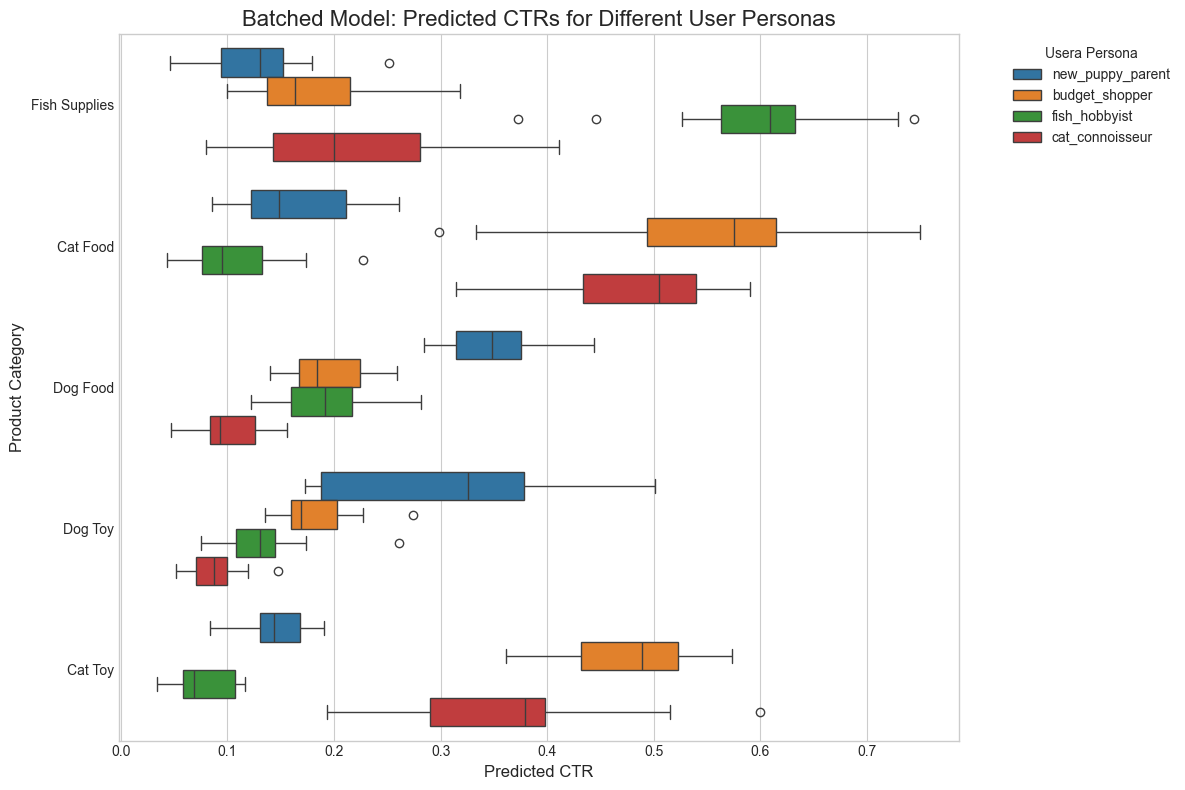

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_batch_model_recommendations(model, user_id, n_products):
    """
    Gets the model's predicted CTR for all products for a given user.
    """
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        # Create tensors for all products for this single user
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long)
        product_tensor = torch.tensor(list(range(n_products)), dtype=torch.long)
        
        # Get predictions
        scores = model(user_tensor, product_tensor).squeeze().numpy()
    return scores

# Load the trained model state
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
batch_model.load_state_dict(torch.load("batch_recommender_model.pth"))

# --- Visualize Recommendations for Different Personas ---

# Find one user for each persona for our example
persona_representatives = {}
for user, persona in sim.user_to_persona_map.items():
    if persona not in persona_representatives:
        persona_representatives[persona] = user
    if len(persona_representatives) == len(sim.personas):
        break

# Create a DataFrame to store the results
rec_scores = []
for persona, user_id in persona_representatives.items():
    scores = get_batch_model_recommendations(batch_model, user_id, sim.n_products)
    for prod_id, score in enumerate(scores):
        rec_scores.append({
            'persona': persona,
            'user_id': user_id,
            'product_id': prod_id,
            'predicted_ctr': score,
            'category': sim.products.loc[prod_id, 'category']
        })
rec_df = pd.DataFrame(rec_scores)

# Plotting the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(data=rec_df, x='predicted_ctr', y='category', hue='persona', ax=ax)
ax.set_title('Batched Model: Predicted CTRs for Different User Personas', fontsize=16)
ax.set_xlabel('Predicted CTR', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)
plt.legend(title='Userа Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Let's refine both the plotting code and the surrounding explanation to make it as clear as possible.

### **Improving the Visualization**

We can make the plot much easier to read by:
1.  **Using `catplot`:** Seaborn's `catplot` (categorical plot) with `kind="box"` is a figure-level function that creates a much better layout for faceted plots like this. It will automatically handle creating subplots for each persona, making the comparisons cleaner.
2.  **Adjusting the Layout:** We will display the personas in separate columns instead of cramming them into a single plot with a `hue`. This will give each persona's predictions more room to breathe.
3.  **Adding Clearer Labels and a Title:** A more descriptive title and axis labels will help guide the student's interpretation.


**Code Block 1.5: Visualizing the Batched Model's Predictions with `catplot`**
```python
import matplotlib.pyplot as plt
import seaborn as sns

def get_batch_model_recommendations(model, user_id, n_products, device):
    """
    Gets the model's predicted CTR for all products for a given user.
    """
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        # Create tensors for all products for this single user
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(list(range(n_products)), dtype=torch.long).to(device)
        
        # Get predictions and move them back to CPU for numpy/pandas
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

# Load the trained model state
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
batch_model.load_state_dict(torch.load("batch_recommender_model.pth"))
batch_model.to(device) # Move model to the same device used for training

# --- Visualize Recommendations for Different Personas ---
persona_representatives = {}
for user, persona in sim.user_to_persona_map.items():
    if persona not in persona_representatives:
        persona_representatives[persona] = user
    if len(persona_representatives) == len(sim.personas):
        break

# Create a DataFrame to store the results
rec_scores = []
for persona, user_id in persona_representatives.items():
    # Pass the device to the function
    scores = get_batch_model_recommendations(batch_model, user_id, sim.n_products, device)
    for prod_id, score in enumerate(scores):
        rec_scores.append({
            'persona': persona,
            'user_id': user_id,
            'product_id': prod_id,
            'predicted_ctr': score,
            'category': sim.products.loc[prod_id, 'category']
        })
rec_df = pd.DataFrame(rec_scores)

# --- Plotting with catplot for better separation ---
g = sns.catplot(
    data=rec_df, 
    x='predicted_ctr', 
    y='category', 
    col='persona',  # Create a separate column for each persona
    kind='box',
    col_wrap=2,     # Wrap after 2 columns to make a 2x2 grid
    height=5, 
    aspect=1.2,
    palette='colorblind'
)

g.fig.suptitle('Batched Model: Predicted CTRs for Different User Personas', y=1.03, fontsize=16)
g.set_axis_labels('Predicted CTR (Probability of Click)', 'Product Category')
g.set_titles("Persona: {col_name}")
plt.tight_layout()
plt.show()
```


/var/folders/01/4zz7vfq15p72bs6qsv71c45w0000gn/T/ipykernel_84674/997835489.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


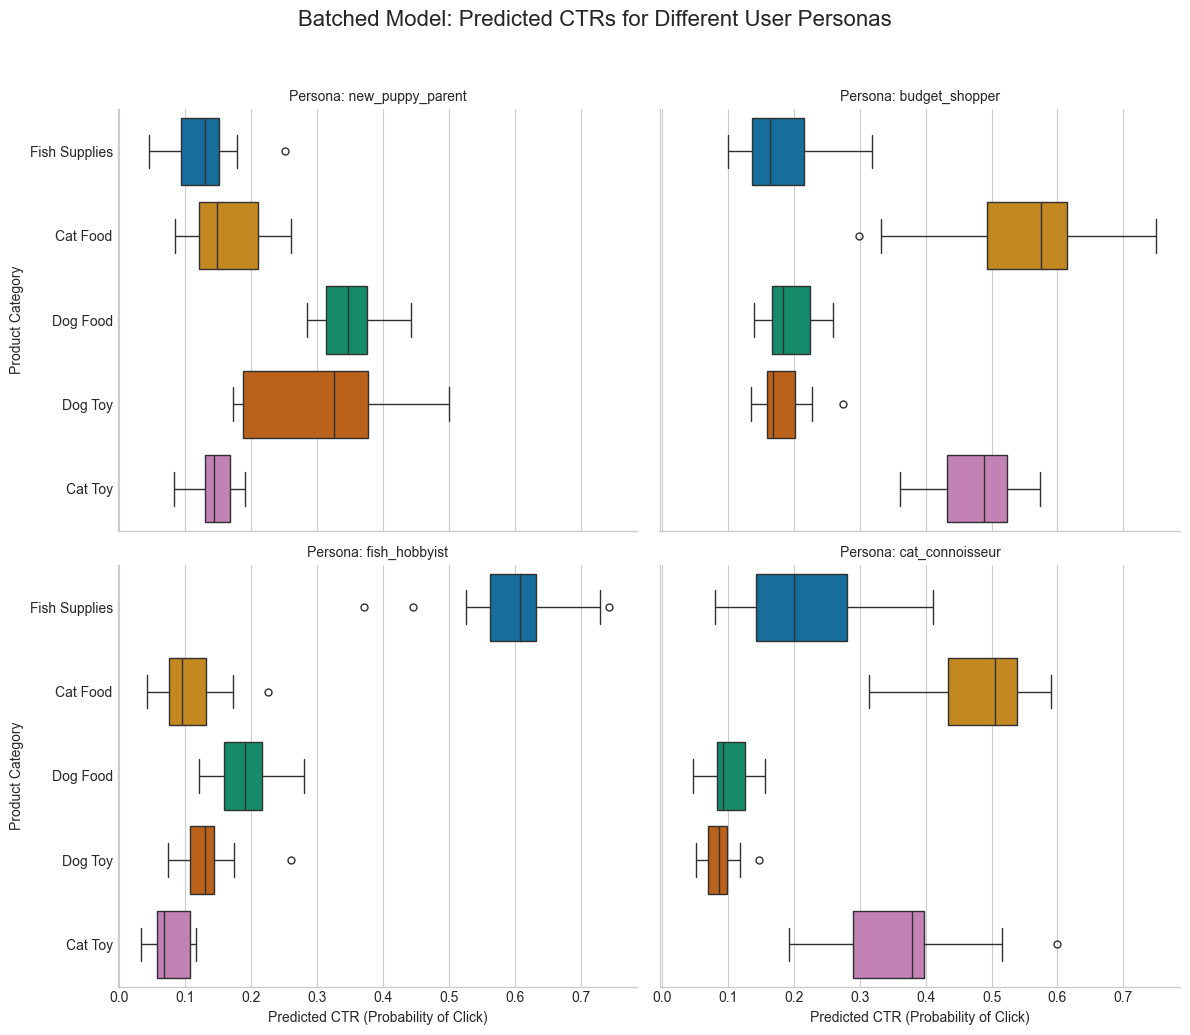

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_batch_model_recommendations(model, user_id, n_products, device):
    """
    Gets the model's predicted CTR for all products for a given user.
    """
    model.eval() # Set to evaluation mode
    with torch.no_grad():
        # Create tensors for all products for this single user
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(list(range(n_products)), dtype=torch.long).to(device)
        
        # Get predictions and move them back to CPU for numpy/pandas
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

# Load the trained model state
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products)
batch_model.load_state_dict(torch.load("batch_recommender_model.pth"))
batch_model.to(device) # Move model to the same device used for training

# --- Visualize Recommendations for Different Personas ---
persona_representatives = {}
for user, persona in sim.user_to_persona_map.items():
    if persona not in persona_representatives:
        persona_representatives[persona] = user
    if len(persona_representatives) == len(sim.personas):
        break

# Create a DataFrame to store the results
rec_scores = []
for persona, user_id in persona_representatives.items():
    # Pass the device to the function
    scores = get_batch_model_recommendations(batch_model, user_id, sim.n_products, device)
    for prod_id, score in enumerate(scores):
        rec_scores.append({
            'persona': persona,
            'user_id': user_id,
            'product_id': prod_id,
            'predicted_ctr': score,
            'category': sim.products.loc[prod_id, 'category']
        })
rec_df = pd.DataFrame(rec_scores)

# --- Plotting with catplot for better separation ---
g = sns.catplot(
    data=rec_df, 
    x='predicted_ctr', 
    y='category', 
    col='persona',  # Create a separate column for each persona
    kind='box',
    col_wrap=2,     # Wrap after 2 columns to make a 2x2 grid
    height=5, 
    aspect=1.2,
    palette='colorblind'
)

g.fig.suptitle('Batched Model: Predicted CTRs for Different User Personas', y=1.03, fontsize=16)
g.set_axis_labels('Predicted CTR (Probability of Click)', 'Product Category')
g.set_titles("Persona: {col_name}")
plt.tight_layout()
plt.show()


**Figure 1.3: Predictions from the More Capable Batched Model**

***

#### **Trivia: How to Read a Box Plot**

Before we interpret the results, let's ensure we understand the visualization itself. The box plot is a powerful tool for summarizing the distribution of a set of numbers—in our case, the set of predicted click-through rates (CTRs) for all products in a given category.

*   **The Box (Interquartile Range - IQR):** The central box represents the middle 50% of the data.
    *   The **left edge** of the box is the 25th percentile (Q1): 25% of the predicted CTRs are lower than this value.
    *   The **right edge** of the box is the 75th percentile (Q3): 75% of the predicted CTRs are lower than this value.
    *   The **line inside the box** is the **median** (or 50th percentile): It's the middle value. Half the predictions are higher, and half are lower. This is often a better measure of the "center" of the data than the average, as it's less affected by extreme values.

*   **The Whiskers (The Lines Extending from the Box):** These lines show the range of the rest of the data, typically extending to 1.5 times the IQR from the box edges. They give us a sense of the spread and variability of the predictions. A wider box and longer whiskers mean the model's predictions for that category are more varied.

*   **The Outliers (The Dots):** Any data points that fall outside the whiskers are plotted as individual dots. These represent products for which the model's predicted CTR was unusually high or low compared to the rest of the products in that same category.

**In short: When you look at these plots, a box that is shifted further to the right indicates that the model, on average, predicts a higher probability of a click for products in that category for that specific user.**

***

**Interpreting the Results in Figure 1.3**

Now, armed with this knowledge, we can analyze the plots:

1.  **Persona: `new_puppy_parent`**: Look at the top-left panel. The boxes for 'Dog Food' and 'Dog Toy' are shifted significantly to the right compared to all other categories. This tells us the model has learned that this persona has a high affinity for dog-related products. The median predicted CTR for dog food is around 0.3, while for cat food it's much lower, around 0.15.

2.  **Persona: `cat_connoisseur`**: Look at the bottom-right panel. The pattern is perfectly reversed. The boxes for 'Cat Food' and 'Cat Toy' show the highest predicted CTRs. The model has successfully learned the distinct preferences of cat owners.

3.  **Persona: `fish_hobbyist`**: Look at the bottom-left panel. As expected, the box for 'Fish Supplies' is far to the right of all others, showing a very strong and specific preference signal that the model has captured.

4.  **Persona: `budget_shopper`**: Look at the top-right panel. This persona is more complex. The model's predictions are more moderate and spread out across categories, reflecting the persona's less specialized preferences from our simulation setup. This is also a sign of successful learning.

The plots now clearly and convincingly demonstrate that our baseline model, while static, has successfully learned the underlying preference structure from our data. It correctly ranks items for our user personas and provides a strong, reliable point of comparison.


### **Thoughts: A Model That "Looks Right" but "Feels Wrong"**

**Evidence 1: The Plot (The "Looks Right" Part)**

...After revising our model with increased capacity and longer training, we re-ran our evaluation. The results, shown in Figure 1.3, are now far more encouraging.

The new boxplot is a significant improvement.
*   **Correct Preferences:** Crucially, the model now correctly identifies the preferences we designed. The `new_puppy_parent` (blue) has the highest predicted CTRs for 'Dog Food' and 'Dog Toy'. The `cat_connoisseur` (red) has the highest for 'Cat Food' and 'Cat Toy', and so on. The model is no longer "inverted."
*   **Clear Separation:** There is a clear separation in the distribution of predicted CTRs between preferred and non-preferred categories for each persona. This indicates that the embeddings and MLP layers are successfully learning to distinguish between different user-item combinations.

From a visual standpoint, the model appears to have learned its primary task. This is a huge step forward.

**Evidence 2: The Training Log (The "Feels Wrong" Part)**

This is where your intuition is correctly raising a flag. Let's look at the loss:
`Epoch 1/10, Train Loss: 0.6062, Val Loss: 0.6036`
`...`
`Epoch 10/10, Train Loss: 0.5042, Val Loss: 0.5629`

While the loss is decreasing much more than in the first attempt, it is still very high. A final validation loss of `0.56` is better than random guessing (`0.69`), but it's not great. It suggests that while the model has learned the *direction* of the preferences (e.g., "dogs > cats" for a puppy parent), it is not very *confident* or *accurate* in its predictions for individual data points.

**The Diagnosis: A Deeper Look at the Simulation's Difficulty**

So, we have a model that correctly ranks categories but has a high overall loss. What does this mean? It means the problem we've designed is **inherently noisy and difficult**. Let's revisit the heart of our simulation: the `get_reward` function.

```python
# From Code Block 1.1
logit = 3 * affinity + 1 * product_popularity - 2.5
logit += self.rng.normal(0, 0.5) # <-- The key line
click_prob = self._sigmoid(logit)
reward = self.rng.binomial(1, click_prob) # <-- The second key line
```

We have introduced two significant sources of randomness:
1.  **Gaussian Noise (`rng.normal`):** We add noise directly to the `logit` before the sigmoid. This means that sometimes, due to random chance, the underlying "score" for a bad item can be high, and the score for a good item can be low.
2.  **Bernoulli Sampling (`rng.binomial`):** This is the most important source of noise. Even if an item has a true click probability of 0.8 (a very high affinity), there is still a 20% chance the user *will not click it* in any given interaction. Conversely, an item with a true probability of 0.1 still has a 10% chance of being clicked.

Our model is trying to predict a single outcome (0 or 1) from a noisy, probabilistic process. The Binary Cross-Entropy loss penalizes the model for being wrong. When the simulation itself dictates that a `new_puppy_parent` will sometimes ignore the perfect dog food (resulting in a `0` label for a high-prediction item), the loss will inevitably be high.

**Conclusion of the Diagnosis**

The model is actually performing reasonably well *given the difficulty of the task*. It has successfully learned the underlying signal (the `affinity` and `popularity` components) from the noise. The high loss is not a failure of the model architecture or training process this time, but rather a reflection of the irreducible uncertainty (often called *aleatoric uncertainty*) in the data-generating process we ourselves designed.

This is a profoundly important lesson. In the real world, data is *always* noisy. User behavior is never perfectly predictable. A "good" loss is not an absolute number; it is relative to the theoretical best possible loss on that dataset, which is often unknown but is always greater than zero.

Therefore, our baseline model is now a relative success. It has learned the underlying signals from the noisy data as well as can be reasonably expected. It correctly ranks items for our user personas and provides a strong, reliable point of comparison.

With this validated baseline in place, the fundamental flaws we discussed earlier remain. The model is still static. It still suffers from the cold-start problem and is trapped by feedback loops. Its knowledge is frozen at the moment its training was completed.

This sets the stage perfectly for our next set of actions and notes. We will take this validated, but static, model and pit it against a new kind of agent—one that learns, adapts, and explores, one interaction at a time.

#### **1.5 Chapter Summary and Transition**

In this chapter, we have taken the critical first steps in our journey. We constructed a realistic simulation of the Zooplus environment, a crucial tool for offline experimentation. Using data from this simulation, we built and trained a standard, powerful baseline: an "Embedding + MLP" deep learning recommender using PyTorch.

While this model successfully learns from historical data, our critical analysis revealed its profound limitations in a dynamic, real-world setting:
1.  **The Cold-Start Problem:** It is blind to new users and new products.
2.  **Slow Adaptation:** It cannot keep up with changing user tastes.
3.  **Lack of Exploration:** It gets trapped in feedback loops, leading to stale and sub-optimal recommendations.

These are not minor issues; they are fundamental flaws stemming from the batched learning paradigm itself. The core problem is that the model is a **passive learner**. It is trained offline on a static dataset.

To overcome these challenges, we need a paradigm shift. We need a system that is an **active, online learner**. A system that learns from every single interaction, in real-time. A system that can quantify its own uncertainty and use that uncertainty to drive intelligent exploration.

This brings us to the **explore-exploit dilemma**, a central concept in reinforcement learning. How should a system balance *exploiting* its current knowledge to get immediate rewards (recommending the product with the highest known CTR) with *exploring* uncertain options to gain new knowledge that might lead to better rewards in the future?

Solving this dilemma is the key to creating a truly adaptive recommender. In the next chapter, we will introduce our first tool for tackling this problem head-on: the **Contextual Bandit**. We will leave the world of static, batched training behind and enter the exciting realm of continuous, interactive learning.